In [1]:
import warnings
from rdkit import RDLogger

# 屏蔽 RDKit 警告
RDLogger.DisableLog('rdApp.*')

# 或屏蔽所有 Python 警告
warnings.filterwarnings("ignore")
# 屏蔽 LightGBM 警告
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

In [2]:
import torch
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score, recall_score, accuracy_score
from xgboost import XGBClassifier
import joblib
from tqdm import tqdm
from rdkit.Chem import Descriptors, AllChem

from sklearn.metrics import roc_curve




# 数据预处理
df = pd.read_csv('../imputed_selected_features_Flam.csv')
labels = df['Flammability'].values
smiles_list = df['SMILES'].tolist()


y = labels
X = np.load('./Flam_smiles_embeddings.npy')

In [ ]:
{'n_estimators': 258, 'max_depth': 16, 'learning_rate': 0.11038806591932318}

In [3]:
# 最优参数
# 最优参数
best_params_xgb = {'n_estimators': 258, 'max_depth': 16, 'learning_rate': 0.11038806591932318,'eval_metric': 'error'  
}


In [4]:
def zzz(model_name, model_class, best_params, X, y):
    # 确保 X 和 y 是 numpy 数组
    X = np.asarray(X)
    y = np.asarray(y)

    # 创建模型并设置最优参数
    model = model_class(**best_params)

    # 五折交叉验证
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 用于存储每一折的预测概率和真实标签
    all_y_prob = []
    all_y_true = []

    # 使用 tqdm 包裹五折交叉验证的每一折
    for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X, y), total=5, desc=f"Training {model_name}")):
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)

        # 获取预测概率
        y_prob = model.predict_proba(X_val)[:, 1]
        all_y_prob.append(y_prob)
        all_y_true.append(y_val)

    # 将所有预测概率和真实标签合并
    all_y_prob = np.concatenate(all_y_prob)
    all_y_true = np.concatenate(all_y_true)
    return all_y_prob,all_y_true

In [5]:
all_y_prob,all_y_true= zzz("XGBoost", XGBClassifier, best_params_xgb, X, y)

Training XGBoost: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import xgboost as xgb
import numpy as np

# 查看 xgboost 版本
print(f"xgboost version: {xgb.__version__}")

# 查看 numpy 版本
print(f"numpy version: {np.__version__}")

xgboost version: 2.1.4
numpy version: 2.2.3


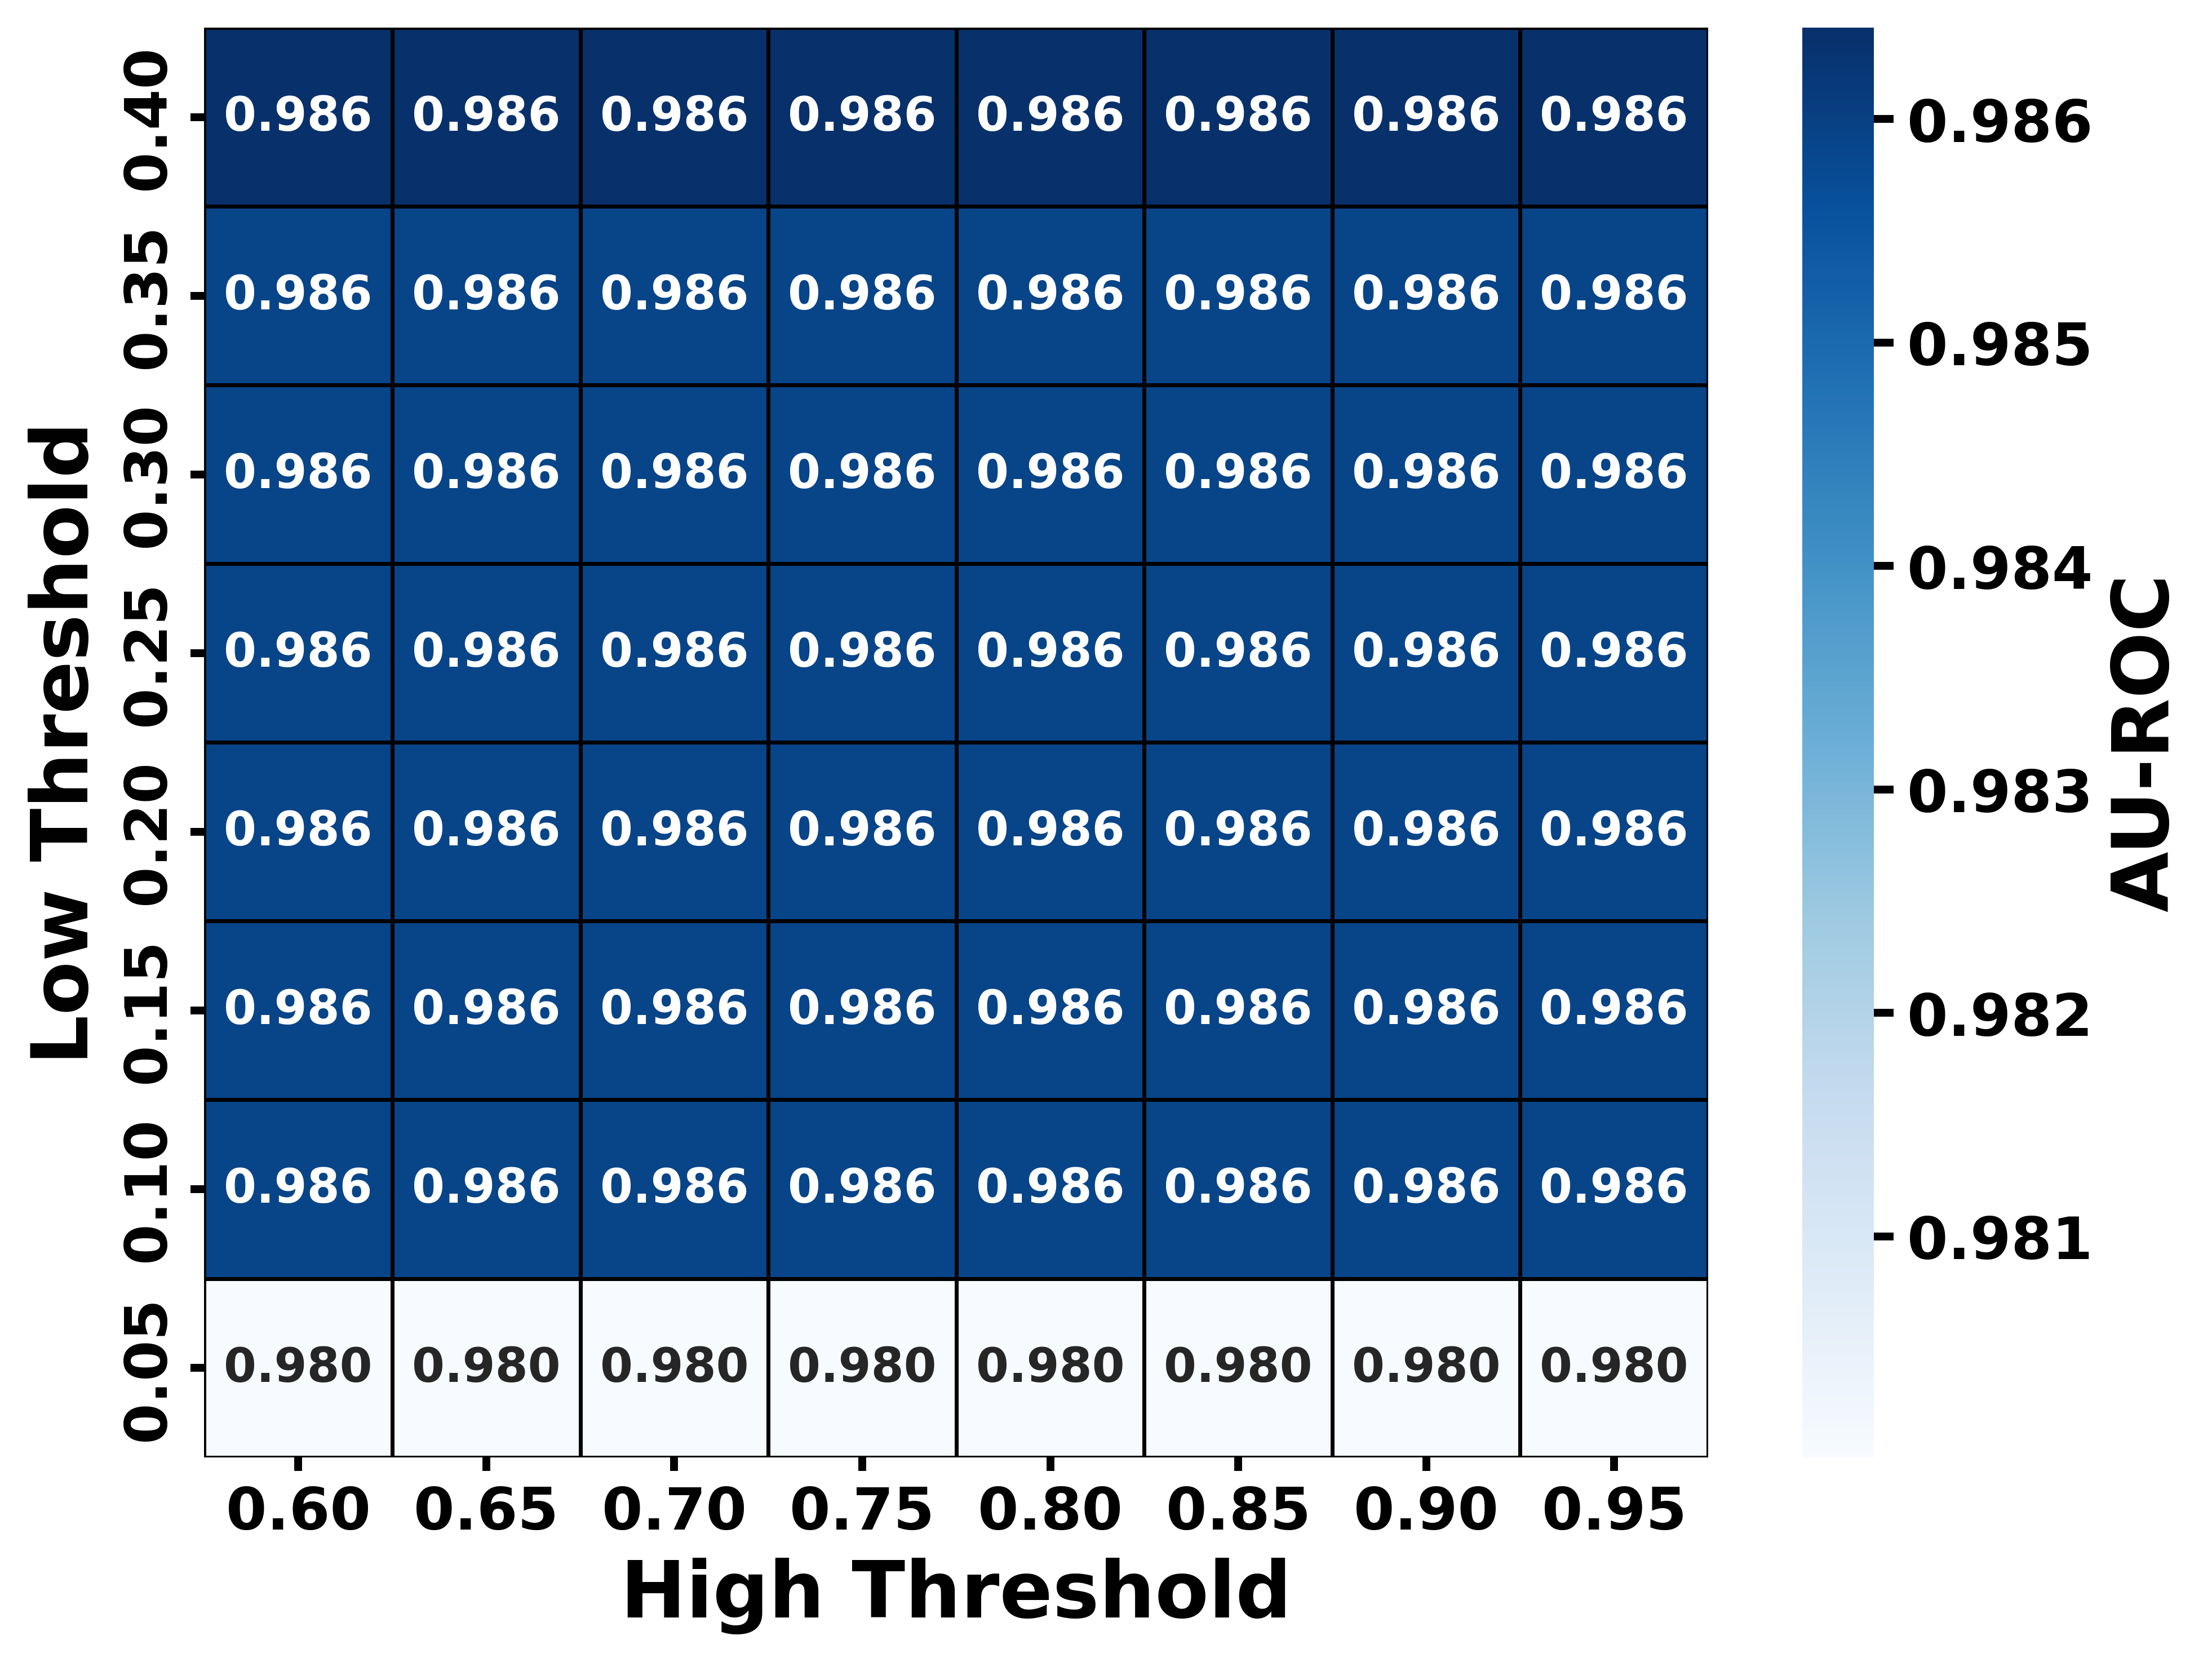

In [7]:
from sklearn.metrics import roc_auc_score

def plot_auroc(all_y_prob,all_y_true):


    # 设置上下界：low 从 0.2 到 0.4，每次步长 0.05，high 从 0.6 到 0.8，每次步长 0.05
    low_values = np.arange(0.05,0.41, 0.05)
    high_values = np.arange(0.6, 1, 0.05)

    # 用于保存每个 (low, high) 对应的 AUC-ROC
    auc_matrix = np.zeros((len(low_values), len(high_values)))

    # 对每个 (low, high) 组合，计算符合条件的样本数目和 AUC-ROC
    for i, low in enumerate(low_values):
        for j, high in enumerate(high_values):
            # 筛选出符合条件的样本
            valid_idx = np.where((all_y_prob <= low) | (all_y_prob >= high))[0]
            
            if len(valid_idx) > 0:  # 只有当 valid_idx 非空时才计算 AUC-ROC
                auc_score = roc_auc_score(all_y_true[valid_idx], all_y_prob[valid_idx])
            else:
                auc_score = np.nan  # 如果没有有效样本，设置为 0 或 NaN
            
            auc_matrix[i, j] = auc_score

    # 创建图形
    plt.figure(figsize=(8, 6), dpi=500)

    vmin = np.min(auc_matrix)  # 最小值)  # 最小值
    #vmax = np.max(accuracy_matrix) * 1.2 # 将最大值减少到最大值的95%
    vmax = np.max(auc_matrix)
    
    yanse = (vmax+vmin)/2

    # 创建带边框的热力图
    ax = sns.heatmap(
        auc_matrix,
        annot=True,              # 在格子中显示数值
        fmt=".3f",               # 保留3位小数
        cmap="Blues",            # 颜色表
        vmin=vmin, vmax=vmax,    # 颜色范围
        xticklabels=[f"{hv:.2f}" for hv in high_values],
        yticklabels=[f"{lv:.2f}" for lv in low_values],
        linewidths=1,            # 网格线宽度
        linecolor='black',       # 网格线颜色
        cbar_kws={"label": "AU-ROC"},  # 颜色条标签
        annot_kws={"size": 12, "weight": "bold"}
    )
    ax.invert_yaxis()
    # 设置坐标轴标签和字体大小
    ax.set_xlabel("High Threshold", fontsize=20,fontweight='bold')
    ax.set_ylabel("Low Threshold", fontsize=20,fontweight='bold')
    ax.tick_params(labelsize=15, width=2)
    # **设置坐标轴刻度字体加粗**
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    # 调整颜色条的字体大小
    cbar = ax.collections[0].colorbar
    #cbar.ax.tick_params(labelsize=15, width=3)  # 设置颜色条刻度字体大小
    # 设置颜色条刻度字体加粗
    cbar.ax.yaxis.set_tick_params(labelsize=15, width=2, length=5)
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')  # 让刻度标签加粗
    cbar.set_label("AU-ROC", fontsize=20, fontweight='bold')  # 颜色条标题字体大小
    # 显示图
    plt.tight_layout()
    plt.show()



# 调用函数进行五折交叉验证并绘图
plot_auroc(all_y_prob,all_y_true)

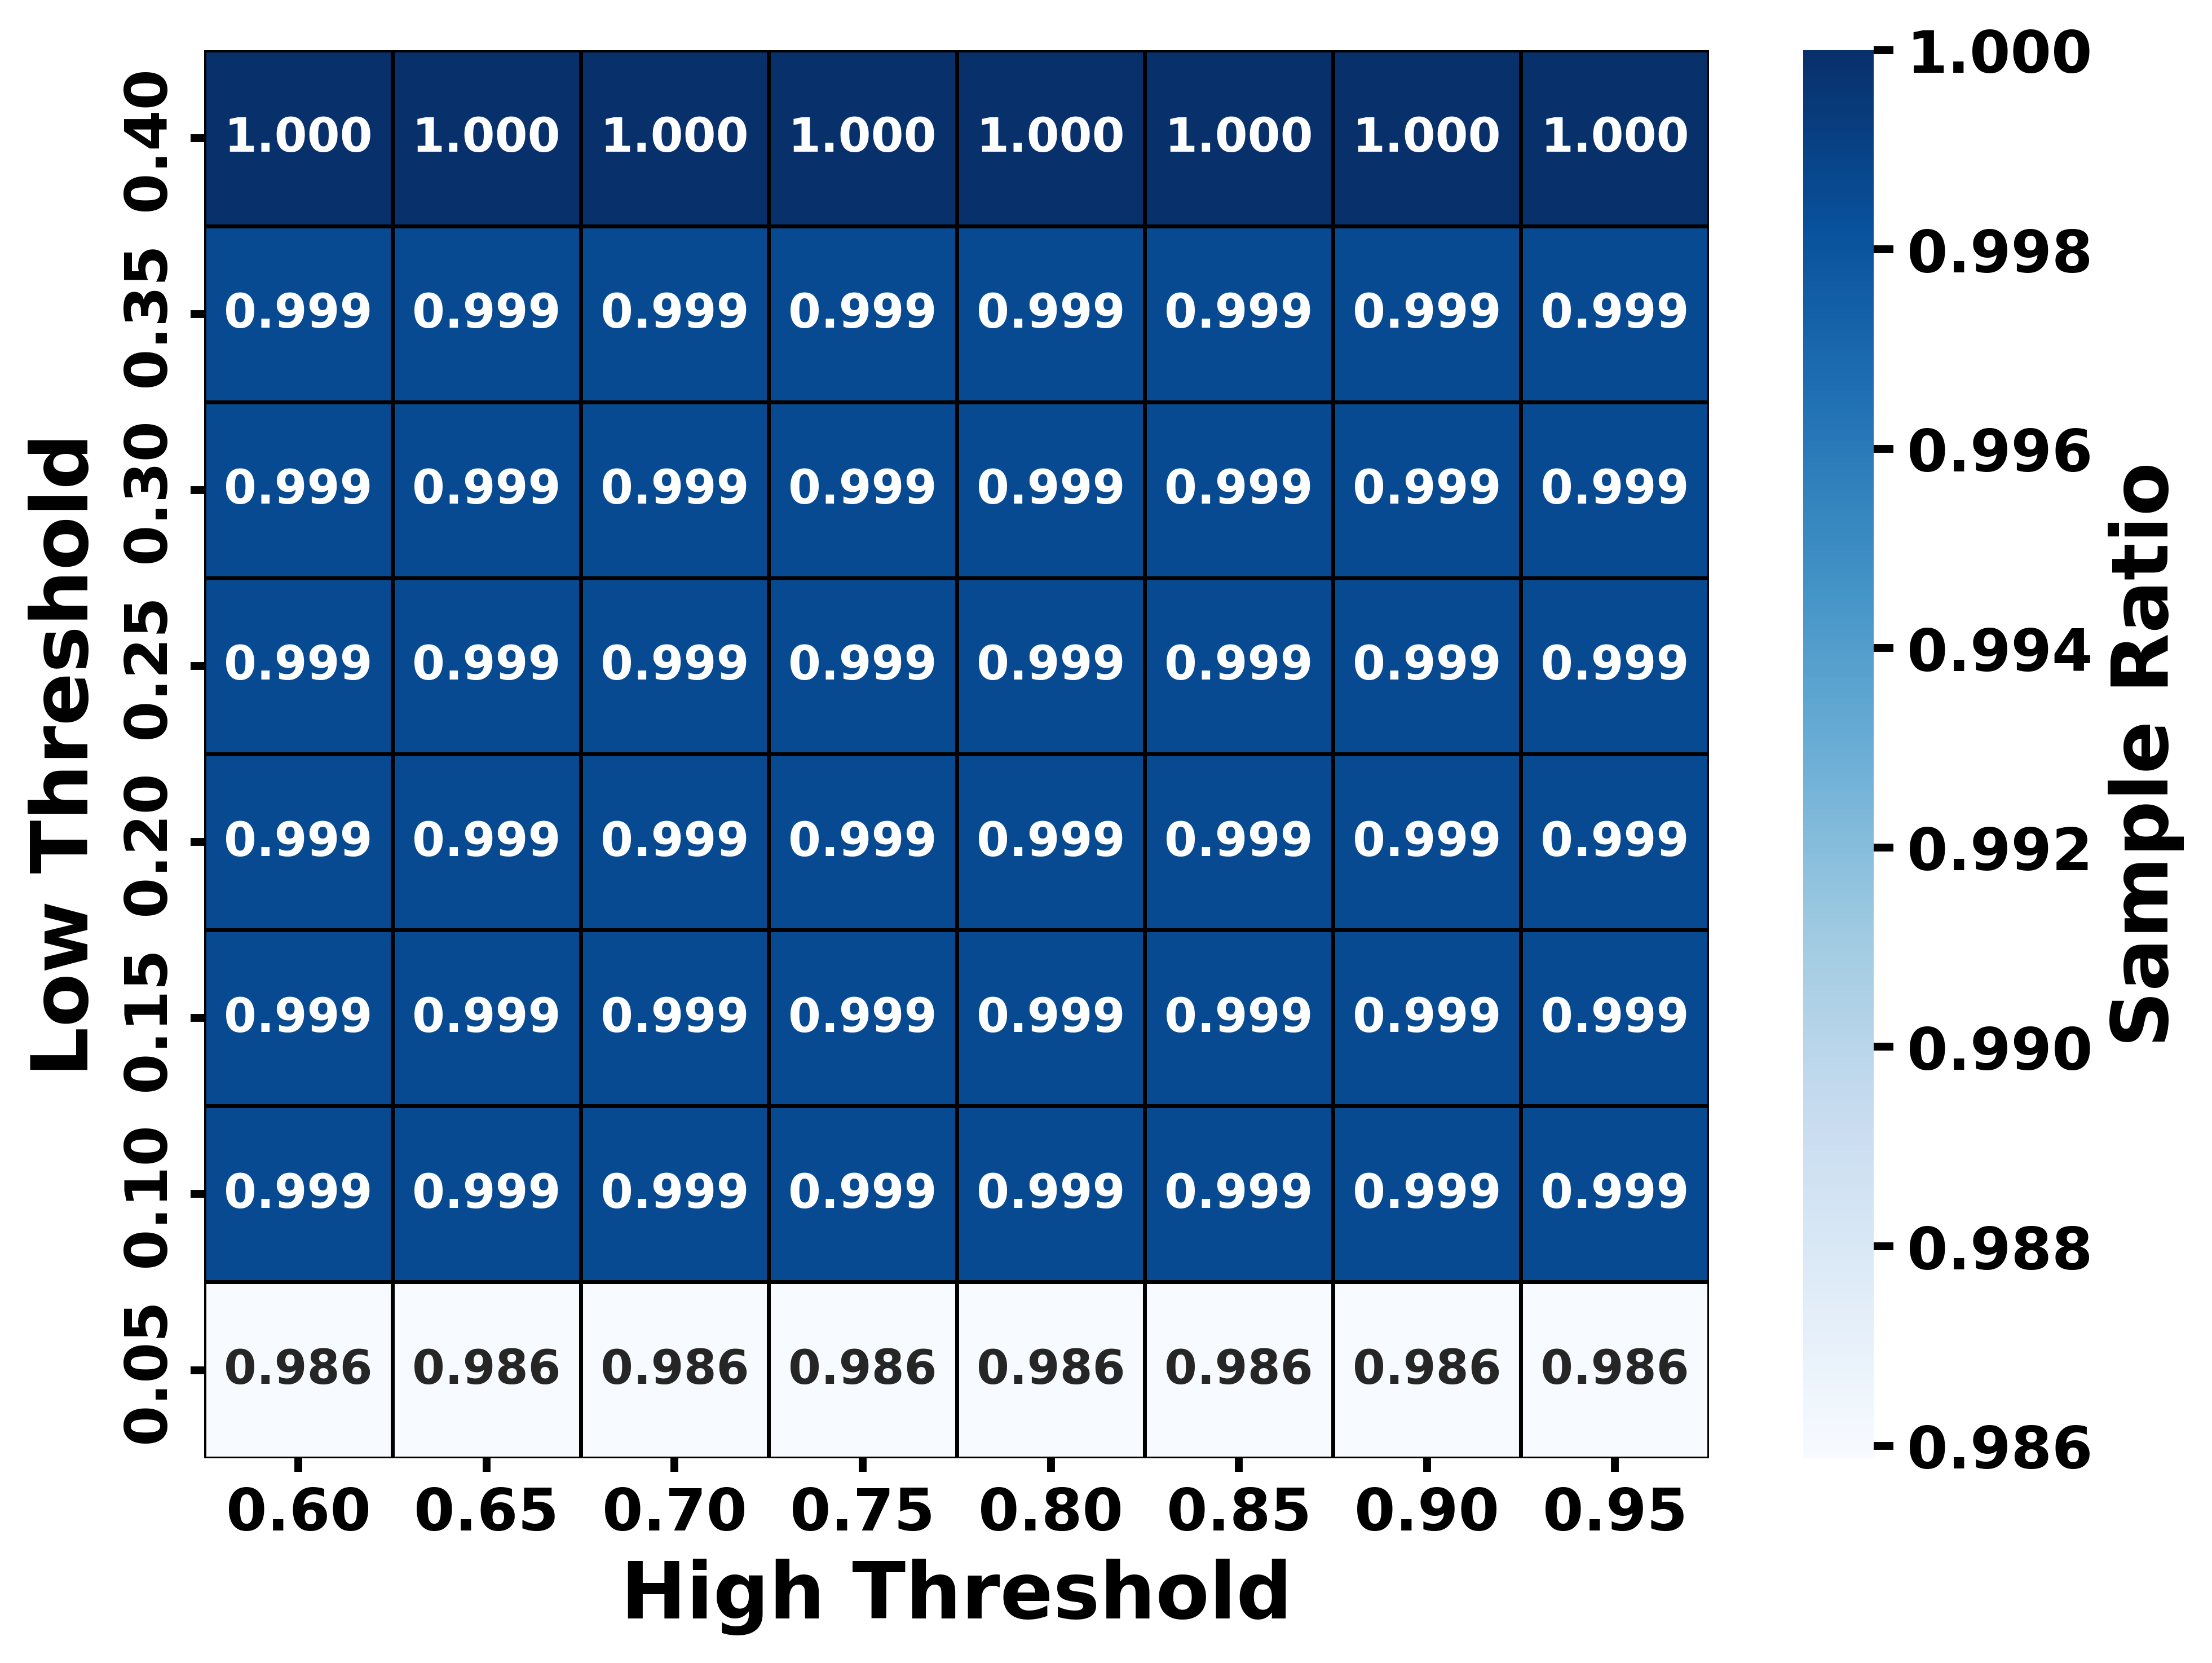

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def plot_ratio(all_y_prob,all_y_true):


    # 设置上下界：low 从 0.2 到 0.4，每次步长 0.05，high 从 0.6 到 0.8，每次步长 0.05
    low_values = np.arange(0.05,0.41, 0.05)
    high_values = np.arange(0.6, 1, 0.05)
    # 用于保存每个 (low, high) 对应的样本占比
    sample_ratio_matrix = np.zeros((len(low_values), len(high_values)))

    # 对每个 (low, high) 组合，计算符合条件的样本占比
    for i, low in enumerate(low_values):
        for j, high in enumerate(high_values):
            # 筛选出符合条件的样本
            valid_idx = np.where((all_y_prob <= low) | (all_y_prob >= high))[0]
            
            if len(valid_idx) > 0:  # 只有当 valid_idx 非空时才计算样本占比
                sample_ratio = len(valid_idx) / len(all_y_true)
            else:
                sample_ratio = 0  # 如果没有有效样本，设置为 0
            
            sample_ratio_matrix[i, j] = sample_ratio

    # 创建图形
    plt.figure(figsize=(8, 6), dpi=500)

    vmin = np.min(sample_ratio_matrix)  # 最小值)  # 最小值
    #vmax = np.max(accuracy_matrix) * 1.2 # 将最大值减少到最大值的95%
    vmax = np.max(sample_ratio_matrix)
    yanse = (vmax+vmin)/2

    

    # 创建带边框的热力图
    ax = sns.heatmap(
        sample_ratio_matrix,
        annot=True,              # 在格子中显示数值
        fmt=".3f",               # 保留3位小数
        cmap="Blues",            # 颜色表
        vmin=vmin, vmax=vmax,    # 颜色范围
        xticklabels=[f"{hv:.2f}" for hv in high_values],
        yticklabels=[f"{lv:.2f}" for lv in low_values],
        linewidths=1,            # 网格线宽度
        linecolor='black',       # 网格线颜色
        cbar_kws={"label": "Sample Ratio"},  # 颜色条标签
        annot_kws={"size": 12, "weight": "bold"}
    )
    ax.invert_yaxis()
    # 设置坐标轴标签和字体大小
    ax.set_xlabel("High Threshold", fontsize=20,fontweight='bold')
    ax.set_ylabel("Low Threshold", fontsize=20,fontweight='bold')
    ax.tick_params(labelsize=15, width=2)
    # **设置坐标轴刻度字体加粗**
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    # 调整颜色条的字体大小
    cbar = ax.collections[0].colorbar
    #cbar.ax.tick_params(labelsize=15, width=3)  # 设置颜色条刻度字体大小
    # 设置颜色条刻度字体加粗
    cbar.ax.yaxis.set_tick_params(labelsize=15, width=2, length=5)
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')  # 让刻度标签加粗
    cbar.set_label("Sample Ratio", fontsize=20, fontweight='bold')  # 颜色条标题字体大小
    # 显示图
    plt.tight_layout()
    plt.show()



# 调用函数进行五折交叉验证并绘图
plot_ratio(all_y_prob,all_y_true)

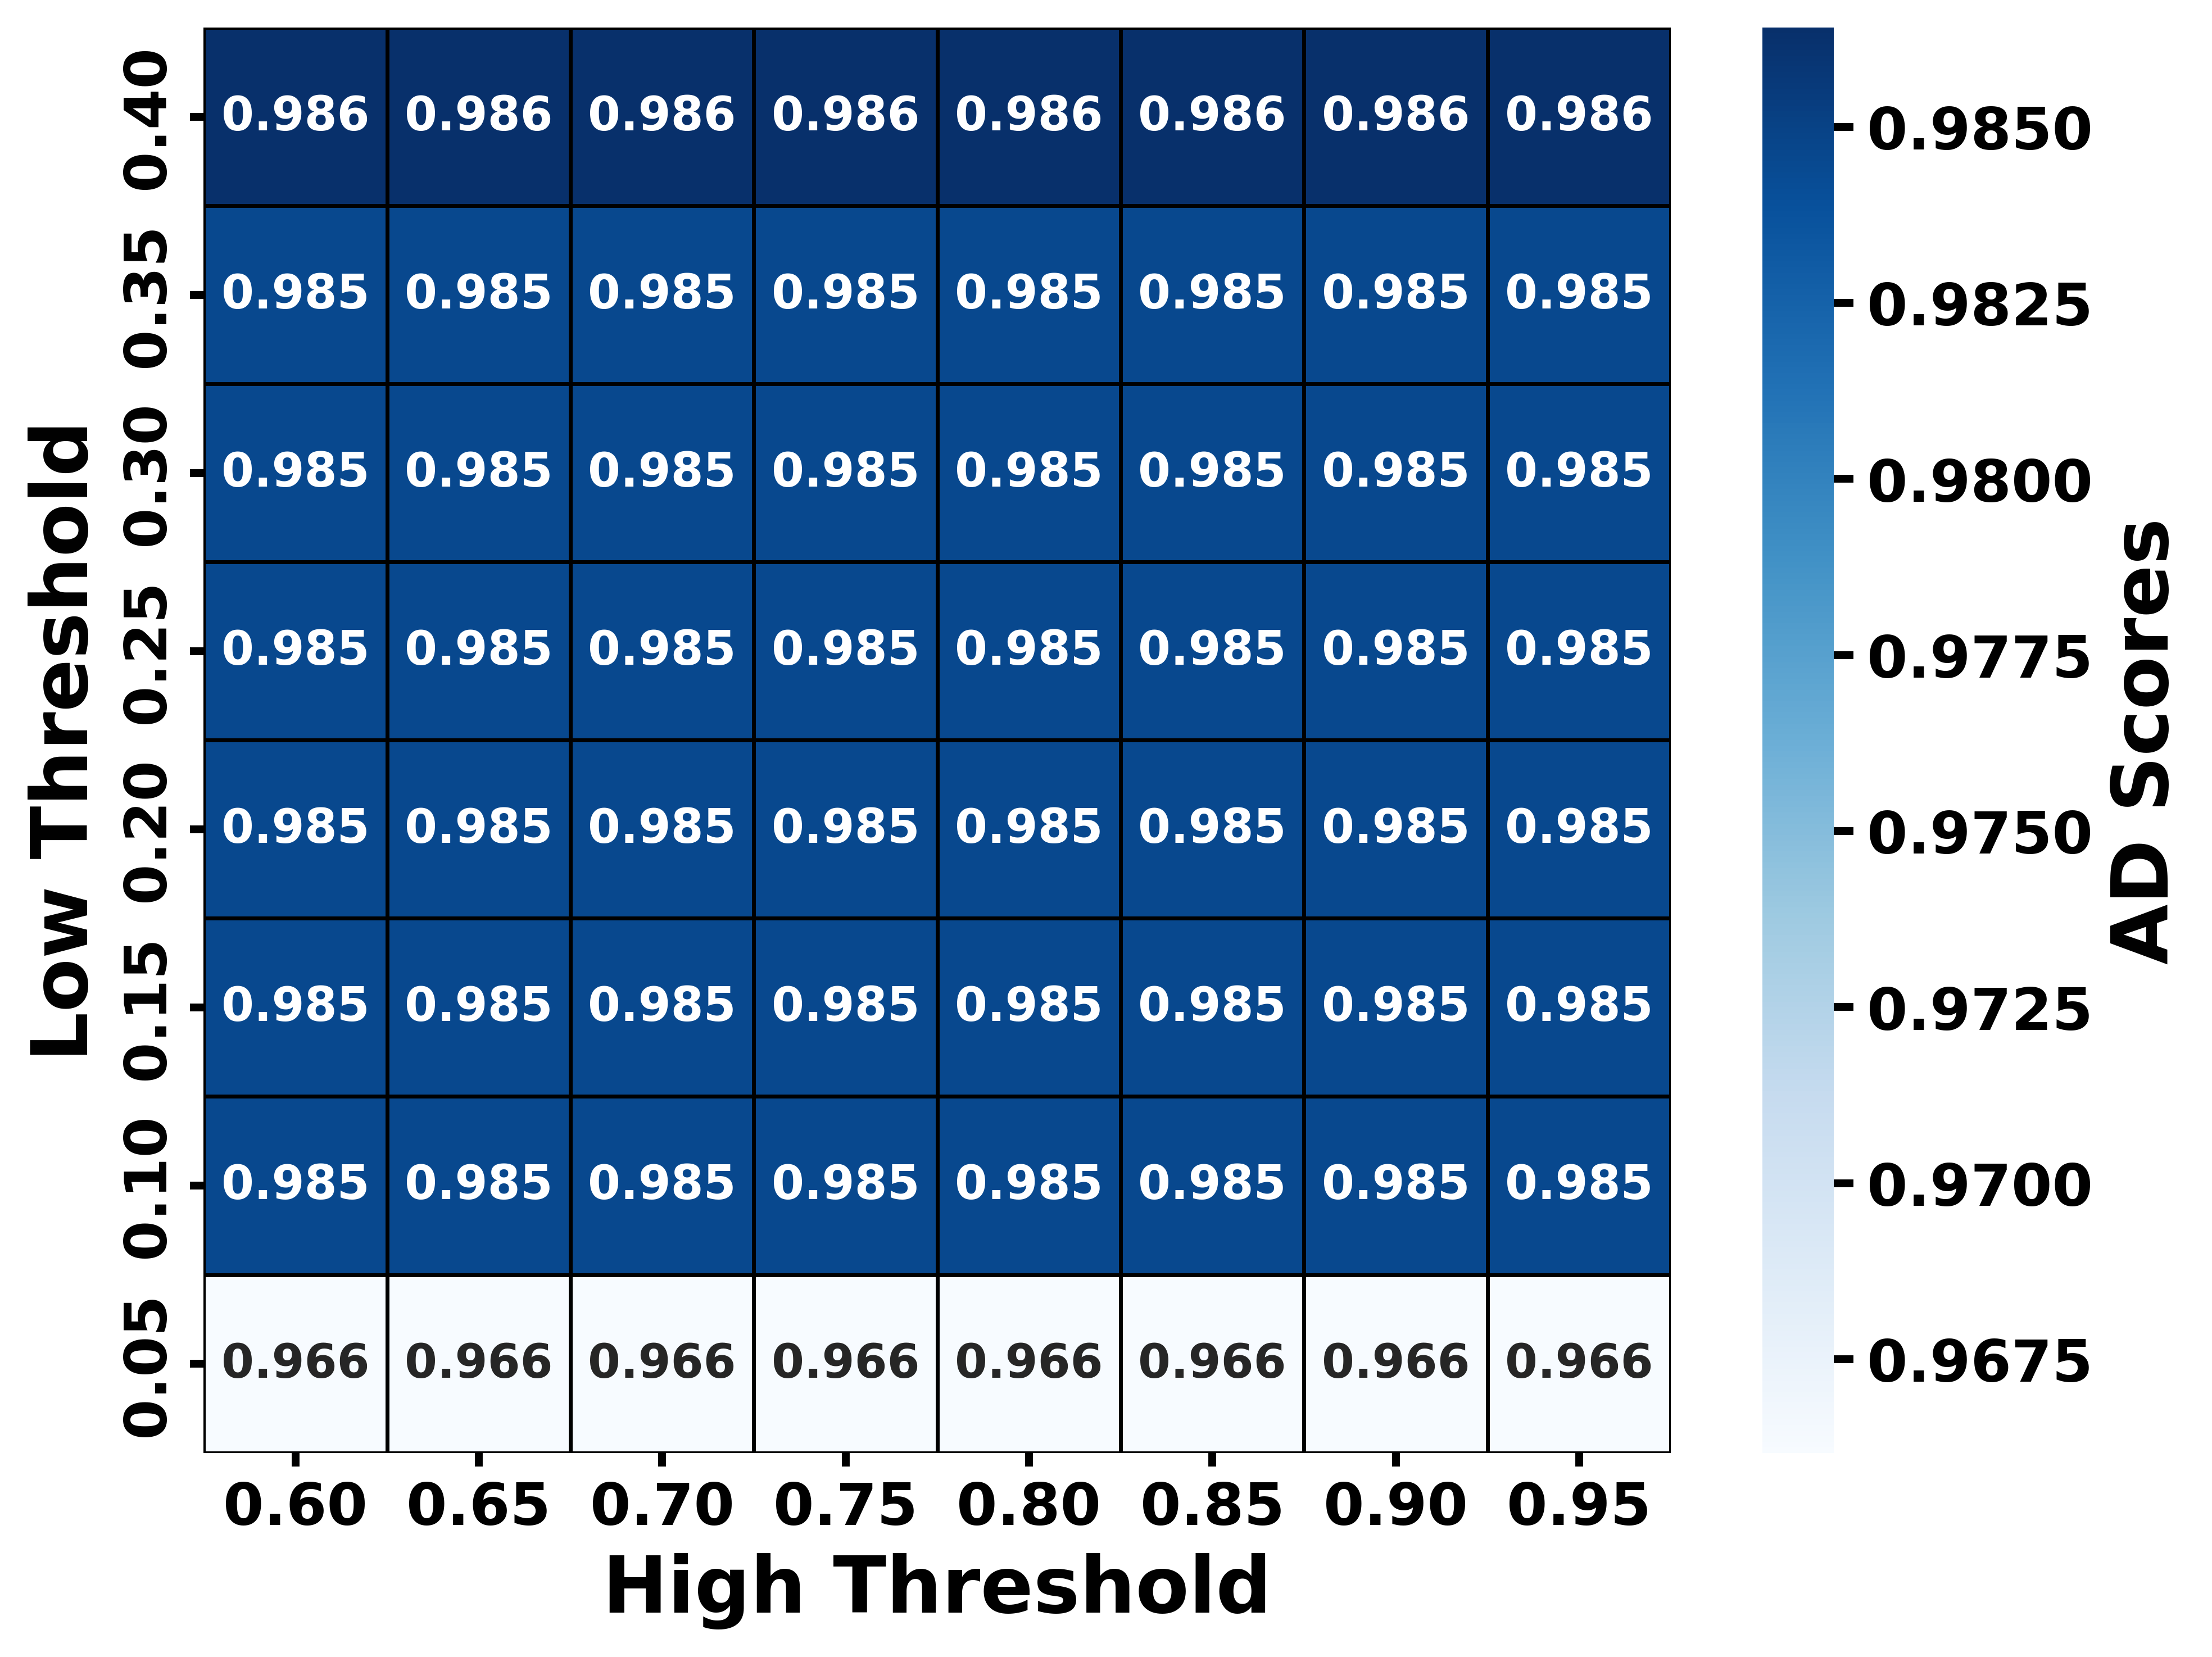

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def plot_ADS(all_y_prob,all_y_true):


    # 设置上下界：low 从 0.2 到 0.4，每次步长 0.05，high 从 0.6 到 0.8，每次步长 0.05
    low_values = np.arange(0.05,0.41, 0.05)
    high_values = np.arange(0.6, 1, 0.05)

    # 用于保存每个 (low, high) 对应的样本占比
    sample_ratio_matrix = np.zeros((len(low_values), len(high_values)))

    # 对每个 (low, high) 组合，计算符合条件的样本占比
    for i, low in enumerate(low_values):
        for j, high in enumerate(high_values):
            # 筛选出符合条件的样本
            valid_idx = np.where((all_y_prob <= low) | (all_y_prob >= high))[0]
            
            if len(valid_idx) > 0:  # 只有当 valid_idx 非空时才计算样本占比
                sample_ratio = len(valid_idx) / len(all_y_true)
            else:
                sample_ratio = 0  # 如果没有有效样本，设置为 0
            
            sample_ratio_matrix[i, j] = sample_ratio

        # 用于保存每个 (low, high) 对应的 AUC-ROC
    auc_matrix = np.zeros((len(low_values), len(high_values)))

    # 对每个 (low, high) 组合，计算符合条件的样本数目和 AUC-ROC
    for i, low in enumerate(low_values):
        for j, high in enumerate(high_values):
            # 筛选出符合条件的样本
            valid_idx = np.where((all_y_prob <= low) | (all_y_prob >= high))[0]
            
            if len(valid_idx) > 0:  # 只有当 valid_idx 非空时才计算 AUC-ROC
                auc_score = roc_auc_score(all_y_true[valid_idx], all_y_prob[valid_idx])
            else:
                auc_score = np.nan  # 如果没有有效样本，设置为 0 或 NaN
            
            auc_matrix[i, j] = auc_score

    matrix = auc_matrix*sample_ratio_matrix
    
    # 创建图形
    plt.figure(figsize=(8, 6), dpi=500)

    vmin = np.min(matrix)  # 最小值)  # 最小值
    #vmax = np.max(accuracy_matrix) * 1.2 # 将最大值减少到最大值的95%
    vmax = np.max(matrix) 
    yanse = (vmax+vmin)/2

    

    # 创建带边框的热力图
    ax = sns.heatmap(
        matrix,
        annot=True,              # 在格子中显示数值
        fmt=".3f",               # 保留3位小数
        cmap="Blues",            # 颜色表
        vmin=vmin, vmax=vmax,    # 颜色范围
        xticklabels=[f"{hv:.2f}" for hv in high_values],
        yticklabels=[f"{lv:.2f}" for lv in low_values],
        linewidths=1,            # 网格线宽度
        linecolor='black',       # 网格线颜色
        cbar_kws={"label": "Sample Ratio"},  # 颜色条标签
        annot_kws={"size": 12, "weight": "bold"}
    )
    ax.invert_yaxis()
    # 设置坐标轴标签和字体大小
    ax.set_xlabel("High Threshold", fontsize=20,fontweight='bold')
    ax.set_ylabel("Low Threshold", fontsize=20,fontweight='bold')
    ax.tick_params(labelsize=15, width=2)
    # **设置坐标轴刻度字体加粗**
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    # 调整颜色条的字体大小
    cbar = ax.collections[0].colorbar
    #cbar.ax.tick_params(labelsize=15, width=3)  # 设置颜色条刻度字体大小
    # 设置颜色条刻度字体加粗
    cbar.ax.yaxis.set_tick_params(labelsize=15, width=2, length=5)
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')  # 让刻度标签加粗
    cbar.set_label("AD Scores", fontsize=20, fontweight='bold')  # 颜色条标题字体大小
    # 显示图
    plt.tight_layout()
    plt.show()



# 调用函数进行五折交叉验证并绘图
plot_ADS(all_y_prob,all_y_true)

In [29]:
import torch
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import optuna
from rdkit.Chem import Descriptors, AllChem
from tqdm import tqdm  # 导入tqdm




# 训练和评估函数
def train_evaluate_model_with_optuna(model_name, model_class, param_func, X, y):
    def objective(trial):
        params = param_func(trial)
        if model_class == SVC:
            params['probability'] = True

        model = model_class(**params)

        # 五折交叉验证
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        pr_auc_scores = []

        # 使用 tqdm 包裹五折交叉验证的每一折
        for train_idx, val_idx in tqdm(skf.split(X, y), total=5, desc=f"Training {model_name}"):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model.fit(X_train, y_train)
            y_prob = model.predict_proba(X_val)[:, 1]
            precision, recall, _ = precision_recall_curve(y_val, y_prob)
            pr_auc = auc(recall, precision)
            pr_auc_scores.append(pr_auc)

        return np.mean(pr_auc_scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    print(f'Best parameters for {model_name}: {study.best_params}')
    best_params = study.best_params
    if model_class == SVC:
        best_params['probability'] = True

    best_model = model_class(**best_params)
    best_model.fit(X, y)
    model_path = f'{model_name}_best_model.joblib'
    joblib.dump(best_model, model_path)
    print(f"Model saved to {model_path}")

# 搜索空间
#def svm_param_func(trial):
#    return {
#        'C': trial.suggest_loguniform('C', 1e-6, 1e+6),
#        'gamma': trial.suggest_loguniform('gamma', 1e-6, 1e+1),
#        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf']),
#        'probability': True
#    }



def xgb_param_func(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

print("Training XGBoost...")
train_evaluate_model_with_optuna("XGBoost", XGBClassifier, xgb_param_func, X, y)

[I 2025-03-08 22:42:35,659] A new study created in memory with name: no-name-02ffc1fa-d7c4-4c90-b2a5-58b4dcb3ce22


Training XGBoost...


Training XGBoost: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]
[I 2025-03-08 22:42:44,556] Trial 0 finished with value: 0.9987924248752471 and parameters: {'n_estimators': 987, 'max_depth': 49, 'learning_rate': 0.669892149100274}. Best is trial 0 with value: 0.9987924248752471.
Training XGBoost: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]
[I 2025-03-08 22:42:48,408] Trial 1 finished with value: 0.9985277765240845 and parameters: {'n_estimators': 427, 'max_depth': 18, 'learning_rate': 0.22085451989637944}. Best is trial 0 with value: 0.9987924248752471.
Training XGBoost: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]
[I 2025-03-08 22:42:58,797] Trial 2 finished with value: 0.998889594430268 and parameters: {'n_estimators': 900, 'max_depth': 22, 'learning_rate': 0.018403203377212567}. Best is trial 2 with value: 0.998889594430268.
Training XGBoost: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]
[I 2025-03-08 22:43:05,656] Trial 3 finished with value: 0.997132536065703 and parameters: {'

Best parameters for XGBoost: {'n_estimators': 258, 'max_depth': 16, 'learning_rate': 0.11038806591932318}
Model saved to XGBoost_best_model.joblib
